In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

batch_size = 64
img_size = [32, 32]
img_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])
# Load the FashionMNIST dataset
training_data = datasets.FashionMNIST(root='data/', download=True, train=True, transform=img_transforms)
test_data = datasets.FashionMNIST(root='data/', download=True, train=False, transform=img_transforms)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [3]:
# set the device to cuda if available 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"using {device} device")

using cuda device


In [4]:
# define the model

class conv_stack(nn.Module):
    def __init__(self, in_channels, out_channels):
        self.kernel_size = 3
        self.in_channels = in_channels
        self.out_channels = out_channels 
        super().__init__()
        if in_channels == out_channels:
            self.seq = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=self.kernel_size, padding="same"),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=self.kernel_size, padding="same"),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU()
            )
            self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding="same")
        else:
            # padding 1 stride 2 scales image down by 2
            # in this case the output channels will be 2 times the size of input channels
            self.seq = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=self.kernel_size, padding=1, stride=2),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=self.kernel_size, padding="same"),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU()
            )
            self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2)
    def forward(self, x):
        return self.conv1x1(x) + self.seq(x)
        

class network(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 32
        self.block_1_size = 16
        self.block_2_size = 32
        self.block_3_size = 64
        self.block_4_size = 128
        self.final_size = 8
        self.fc_size = 10 # total number of classes
        self.avg_pool = nn.AvgPool2d(self.final_size) # global average pool 

        # Layers
        self.conv7x7 = nn.Conv2d(in_channels=1, out_channels=self.block_1_size, kernel_size=7, stride=2, padding=3) # halves by two
        self.batchNorm = nn.BatchNorm2d(num_features=self.block_1_size)
        self.pool_1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.ReLU = nn.ReLU()
        # first set of convolutions
        self.conv_1_3x3 = nn.Sequential(
            *[conv_stack(self.block_1_size, self.block_1_size) for i in range(3)]
            )
        # second set of convolutions        
        self.conv_2_3x3 = nn.Sequential(
            conv_stack(self.block_1_size, self.block_2_size),
            *[conv_stack(self.block_2_size, self.block_2_size) for i in range(3)]
            )
        self.conv_3_3x3 = nn.Sequential(
            conv_stack(self.block_2_size, self.block_3_size),
            *[conv_stack(self.block_3_size, self.block_3_size) for i in range(5)]
            )

        self.conv_4_3x3 = nn.Sequential(
            conv_stack(self.block_3_size, self.block_4_size),
            *[conv_stack(self.block_4_size, self.block_4_size) for i in range(2)]
            )
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(self.block_1_size, self.fc_size) # change to block_4_size after finishing up
    def forward(self, x):
        y = self.conv7x7(x)
        y = self.batchNorm(y)
        y = self.ReLU(y)
        y = self.pool_1(y)
        y = self.conv_1_3x3(y)
        y = self.avg_pool(y)
        y = self.flatten(y)
        logits = self.fc(y)
        return logits
model = network().to(device)
print(model)

network(
  (avg_pool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (conv7x7): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (batchNorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (ReLU): ReLU()
  (conv_1_3x3): Sequential(
    (0): conv_stack(
      (seq): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (conv1x1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), padding=same)
    )
    (1): conv_stack(
      (seq): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 

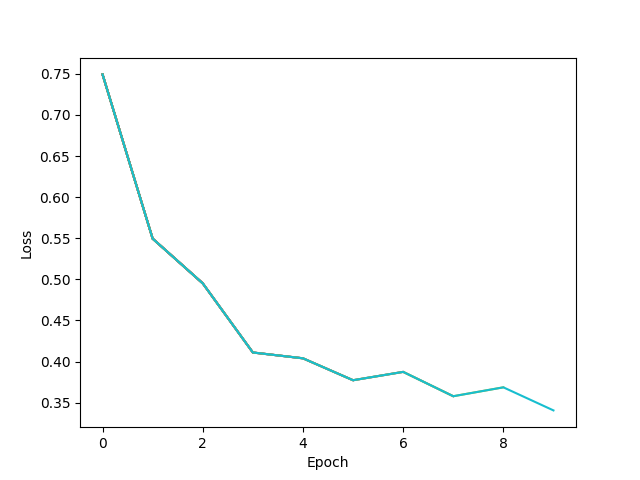

In [5]:
# trains the model

def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        # prediction
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backpropagate
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return correct, test_loss


num_epochs = 10
weight_decay =  0.0001
momentum = 0.9
# learning_rate = 0.1 # divide by 10 on plateau


learning_rate = 1e-3 # remove later, for testing


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

loss = []
# start the training cycle

%matplotlib widget

fig, ax = plt.subplots()
for epoch in range(num_epochs):
    train(train_dataloader, model, loss_fn, optimizer)
    accuraccy, epoch_loss = test(test_dataloader, model, loss_fn)    
    loss.append(epoch_loss) 
    print(f"Epoch {epoch}: Accuraccy={accuraccy*100:.2f}%")
    ax.plot(torch.arange(epoch+1), loss)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    display(fig)
    clear_output(wait = True)

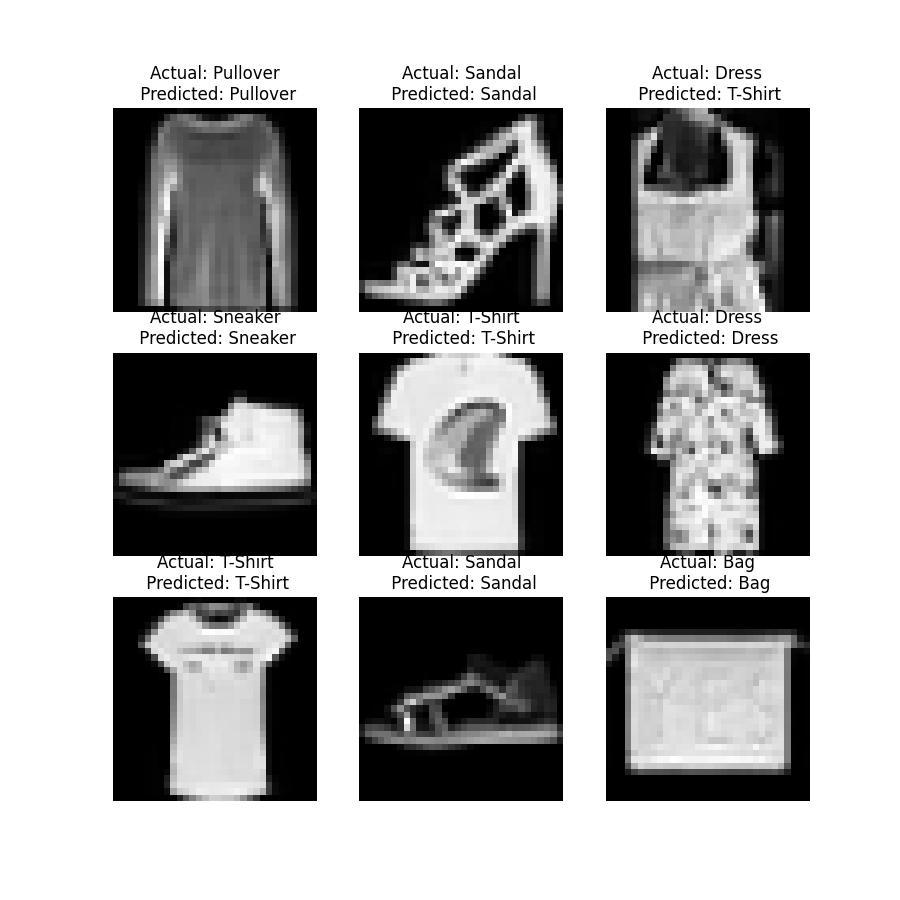

In [6]:
model.eval()
with torch.no_grad():
    # x = []
    # # load 9 images
    # for _ in range(9):
    #     img = torch.randn(3, 224, 224) # load your actual image here and transform it to a tensor
    #     x.append(img)
    # x = torch.stack(x)
    # print(x.shape)

    # out = model(x)


    labels_map = {
        0: "T-Shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }
    x = []
    y = []
    figure = plt.figure(figsize=(9, 9))
    cols, rows = 3, 3
    for i in range(rows*cols):
        # gets an image ID
        sample_idx = torch.randint(len(training_data), size=(1,)).item()
        # gets and stores the image and its label
        img, label = training_data[sample_idx]
        x.append(img)
        y.append(label)
    x = torch.stack(x).to(device)
    pred = model(x)
    pred = torch.argmax(pred, dim=1)
    pred = pred.cpu().numpy()
    x = x.cpu().numpy()
    for i in range(rows*cols):
        figure.add_subplot(rows, cols, i+1)
        plt.title(f"Actual: {labels_map[y[i]]}\n Predicted: {labels_map[pred[i]]}")
        plt.axis("off")
        plt.imshow(x[i,...].squeeze(), cmap="gray")
    plt.show()